In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
fz = np.load('../full_gsat_fs.pt.npy')
mz = np.load('../mask_gsat_fs.pt.npy')

print('fz', fz.shape)
print('mz', mz.shape)

fz (1000, 17)
mz (1000, 17)


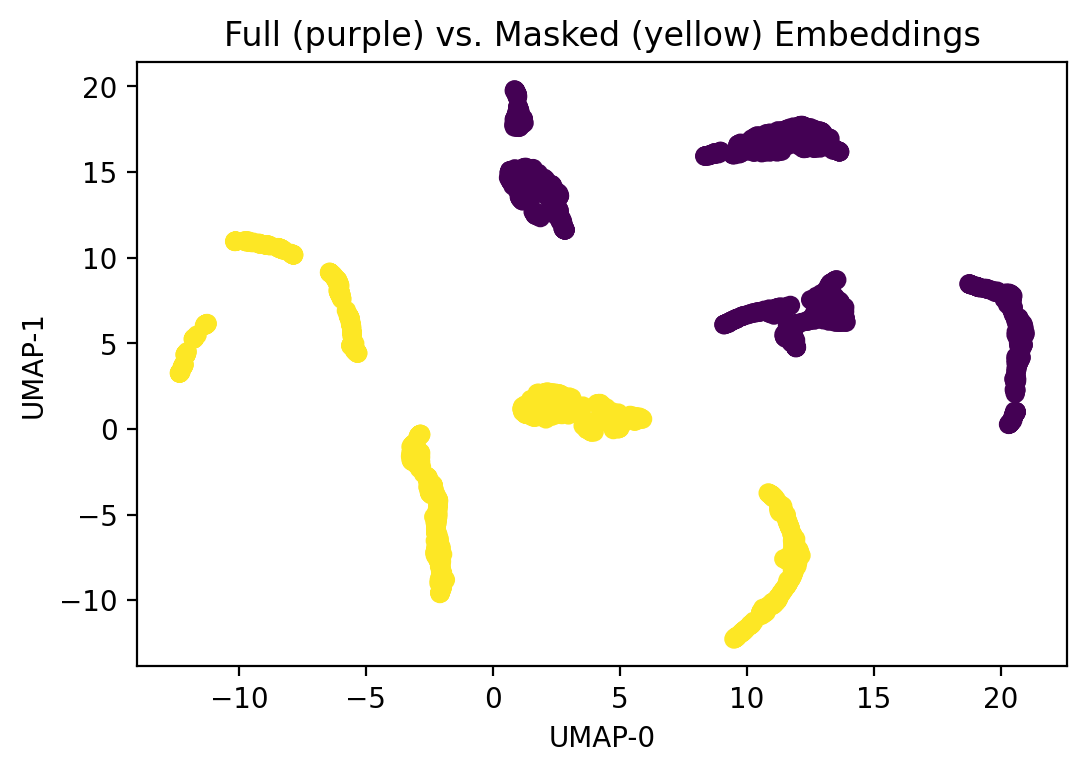

In [3]:
from sklearn.manifold import TSNE
import umap

tsne_z = umap.UMAP().fit_transform(np.concatenate([fz, mz], axis=0))

fig = plt.gcf()
fig.set_dpi(200)
plt.scatter(tsne_z[:,0], tsne_z[:,1], c = (([0] * fz.shape[0]) + ([1] * mz.shape[0])))
plt.title('Full (purple) vs. Masked (yellow) Embeddings')
plt.xlabel('UMAP-0')
plt.ylabel('UMAP-1')
plt.show()

/home/owq978/.conda/envs/tXAI/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/owq978/.conda/envs/tXAI/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/owq978/.conda/envs/tXAI/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/owq978/.conda/envs/tXAI/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


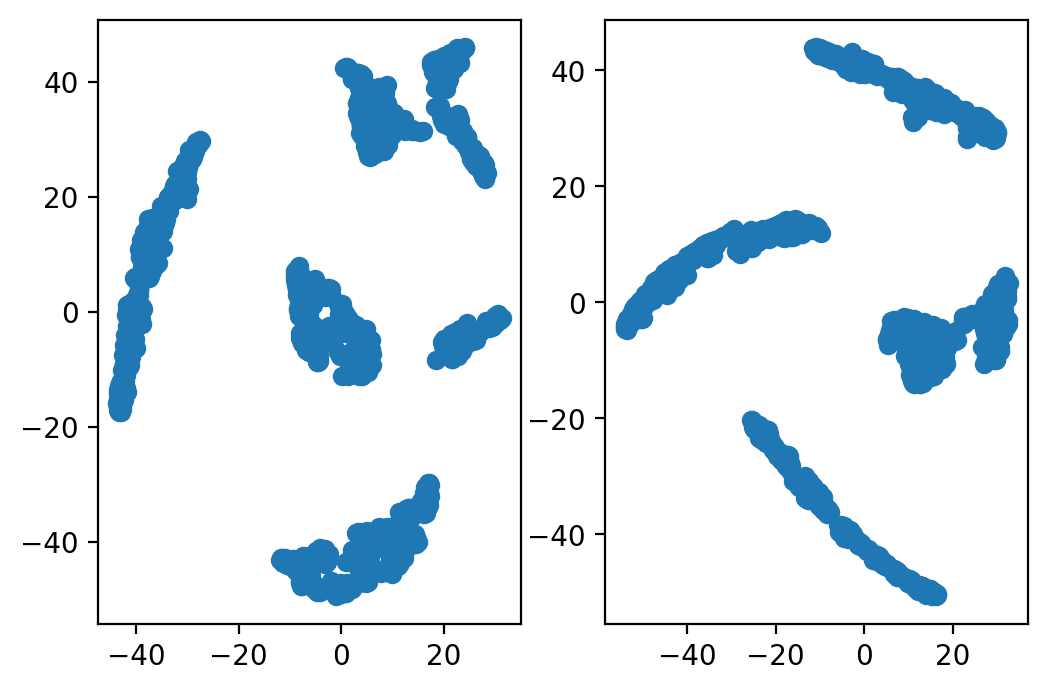

In [4]:
# Separate:

fig, (ax1, ax2) = plt.subplots(1, 2, dpi = 200)

tsne_fz = TSNE().fit_transform(fz)
ax1.scatter(tsne_fz[:,0], tsne_fz[:,1])

tsne_mz = TSNE().fit_transform(mz)
ax2.scatter(tsne_mz[:,0], tsne_mz[:,1])

plt.show()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.54it/s]


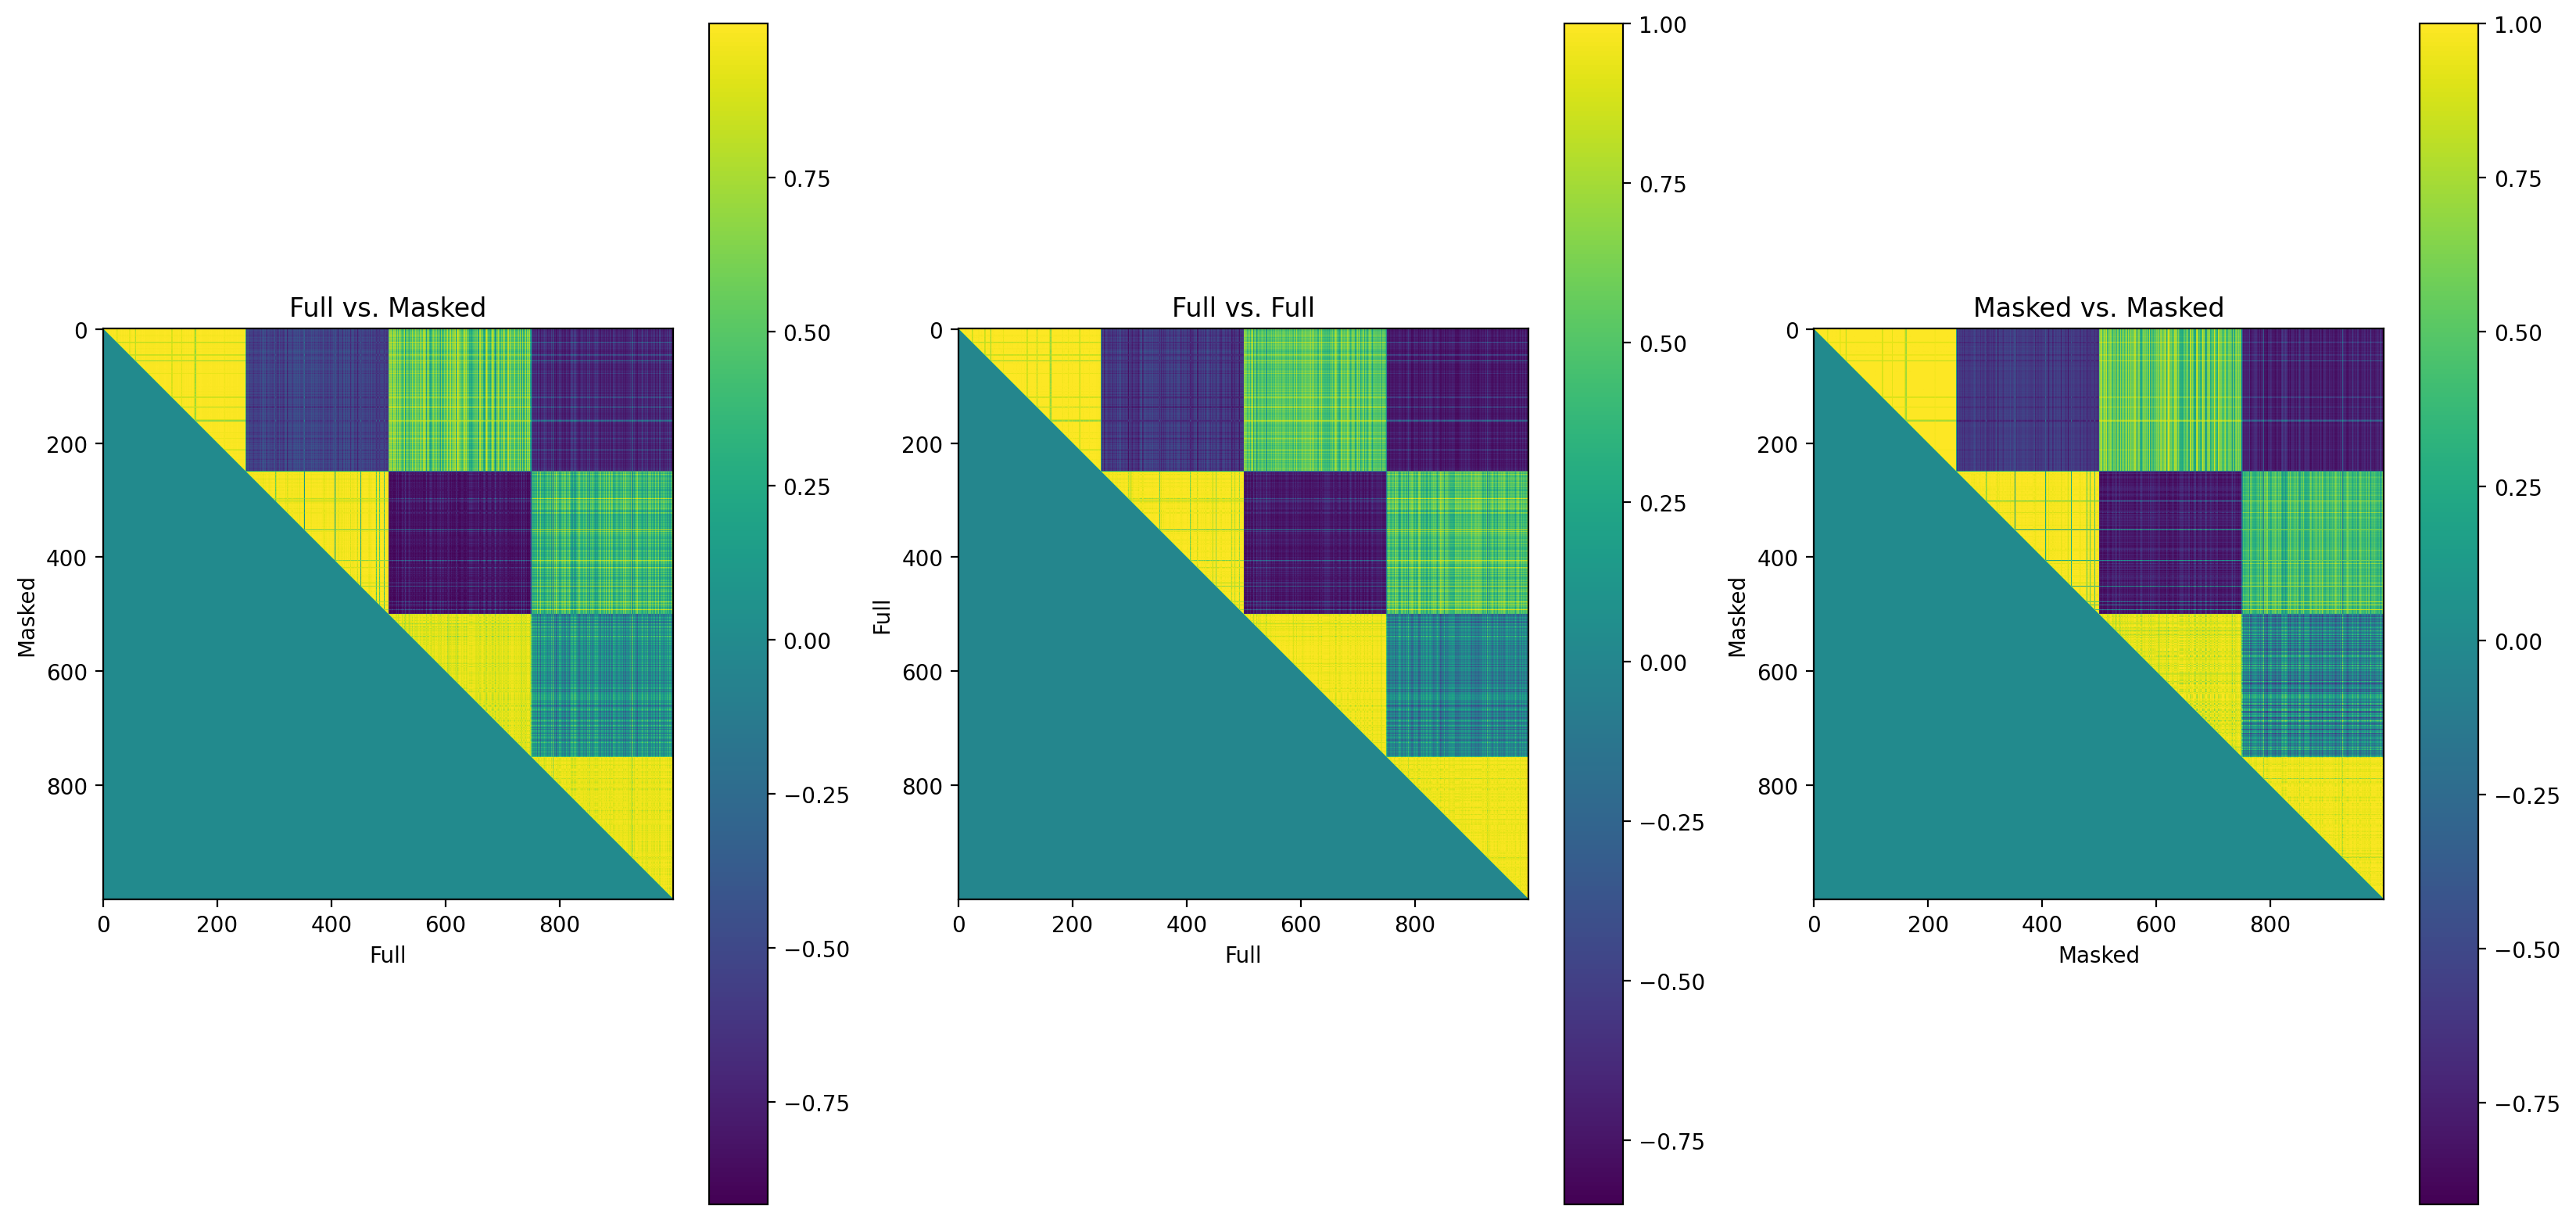

In [5]:
import torch
from txai.utils.cl_metrics import sim_mat

smz = sim_mat(torch.from_numpy(fz), torch.from_numpy(mz))
smf = sim_mat(torch.from_numpy(fz), torch.from_numpy(fz))
smm = sim_mat(torch.from_numpy(mz), torch.from_numpy(mz))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, dpi = 200, figsize = (20, 10))

cbar = ax1.imshow(smz)
plt.colorbar(cbar, ax = ax1)
ax1.set_title('Full vs. Masked')
ax1.set_xlabel('Full')
ax1.set_ylabel('Masked')

cbar = ax2.imshow(smf)
plt.colorbar(cbar, ax = ax2)
ax2.set_title('Full vs. Full')
ax2.set_xlabel('Full')
ax2.set_ylabel('Full')

cbar = ax3.imshow(smm)
plt.colorbar(cbar, ax = ax3)
ax3.set_title('Masked vs. Masked')
ax3.set_xlabel('Masked')
ax3.set_ylabel('Masked')

plt.show()

In [6]:
import umap

In [7]:
umap_z = umap.UMAP().fit_transform(np.concatenate([fz, mz], axis=0))
print(umap_z.shape)

(2000, 2)


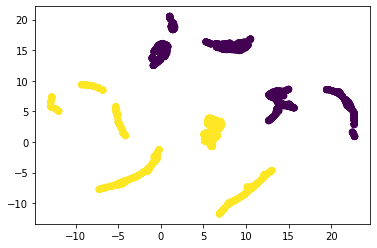

In [8]:
plt.scatter(umap_z[:,0], umap_z[:,1], c = (([0] * fz.shape[0]) + ([1] * mz.shape[0])))
plt.show()

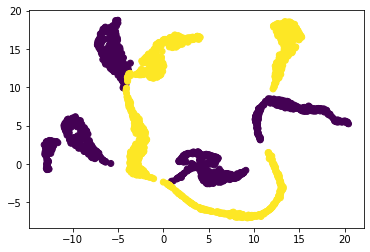

In [9]:
umap_z = umap.UMAP(n_neighbors = 50, min_dist = 0.5, metric="cosine").fit_transform(np.concatenate([fz, mz], axis=0))

plt.scatter(umap_z[:,0], umap_z[:,1], c = (([0] * fz.shape[0]) + ([1] * mz.shape[0])))
plt.show()

In [10]:
# Random permutation experiment:
inds = np.random.choice(np.arange(mz.shape[0]), size = (mz.shape[0],), replace = False)

In [11]:
from numpy.linalg import norm
def batched_cosine_sim(z1, z2):
    sim = []
    for i in range(z1.shape[0]):
        s = np.dot(z1[i,:], z2[i,:]) / (norm(z1[i,:]) * norm(z2[i,:]))
        sim.append(s)
    return sim

In [12]:
# Compute shuffled sims
shuffle_sim = batched_cosine_sim(fz, mz[inds,:])
print('Shuffled', np.mean(shuffle_sim))

Shuffled 0.09935962


In [13]:
# What about inter-class?
y = ([0] * 250) + ([1] * 250) + ([2] * 250) + ([3] * 250)
print(fz.shape)
y = np.array(y)
print(y.shape)

(1000, 17)
(1000,)


In [14]:
sim_matrix_fz = []
sim_matrix_mf = []
sim_matrix_shuffle_mf = []

for yi in np.unique(y):
    # 1. shuffle
    nyi = (y == yi).sum()
    rand_inds = np.random.choice(np.nonzero(y == yi)[0], size = nyi, replace = False)
    
    # Fz computation:
    sim1 = batched_cosine_sim(fz[y == yi,:], mz[y == yi,:])
    sim_matrix_mf.append(sim1)
    
    sim2 = batched_cosine_sim(fz[y == yi,:], fz[y == yi,:])
    sim_matrix_fz.append(sim2)
    
    mz_r = mz[rand_inds,:]
    sim3 = batched_cosine_sim(fz[y == yi,:], mz_r)
    sim_matrix_shuffle_mf.append(sim3)
    

In [15]:
np.nonzero(y == yi)[0].shape

(250,)

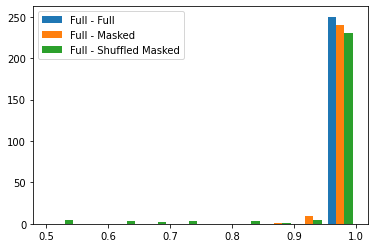

In [16]:
#for i in range(4):
plt.hist([sim_matrix_fz[0], sim_matrix_mf[0], sim_matrix_shuffle_mf[0]], label = ['Full - Full', 'Full - Masked', 'Full - Shuffled Masked'])
# plt.hist(sim_matrix_mf)
plt.legend()
plt.show()


In [22]:
sim_matrix_fz = []
sim_matrix_mf = []
sim_matrix_shuffle_mf = []
sim_matrix_shuffle_f = []

y = ([0] * 250) + ([1] * 250) + ([2] * 250) + ([3] * 250)

xl, yl = np.meshgrid(np.arange(np.unique(y).shape[0]), np.arange(np.unique(y).shape[0]))

for y1i, y2i in zip(xl.flatten(), yl.flatten()):
    # 1. shuffle
    nyi = (y == y2i).sum()
    rand_inds = np.random.choice(np.nonzero(y == y2i)[0], size = nyi, replace = False)
    
    # Fz computation:
    sim1 = batched_cosine_sim(fz[y == y1i,:], mz[y == y2i,:])
    sim_matrix_mf.append(sim1)
    
    sim2 = batched_cosine_sim(fz[y == y1i,:], fz[y == y2i,:])
    sim_matrix_fz.append(sim2)
    
    mz_r = mz[rand_inds,:]
    sim3 = batched_cosine_sim(fz[y == y1i,:], mz_r)
    sim_matrix_shuffle_mf.append(sim3)
    
    sim4 = batched_cosine_sim(fz[rand_inds,:], fz[y == y1i,:])
    sim_matrix_shuffle_f.append(sim4)
    


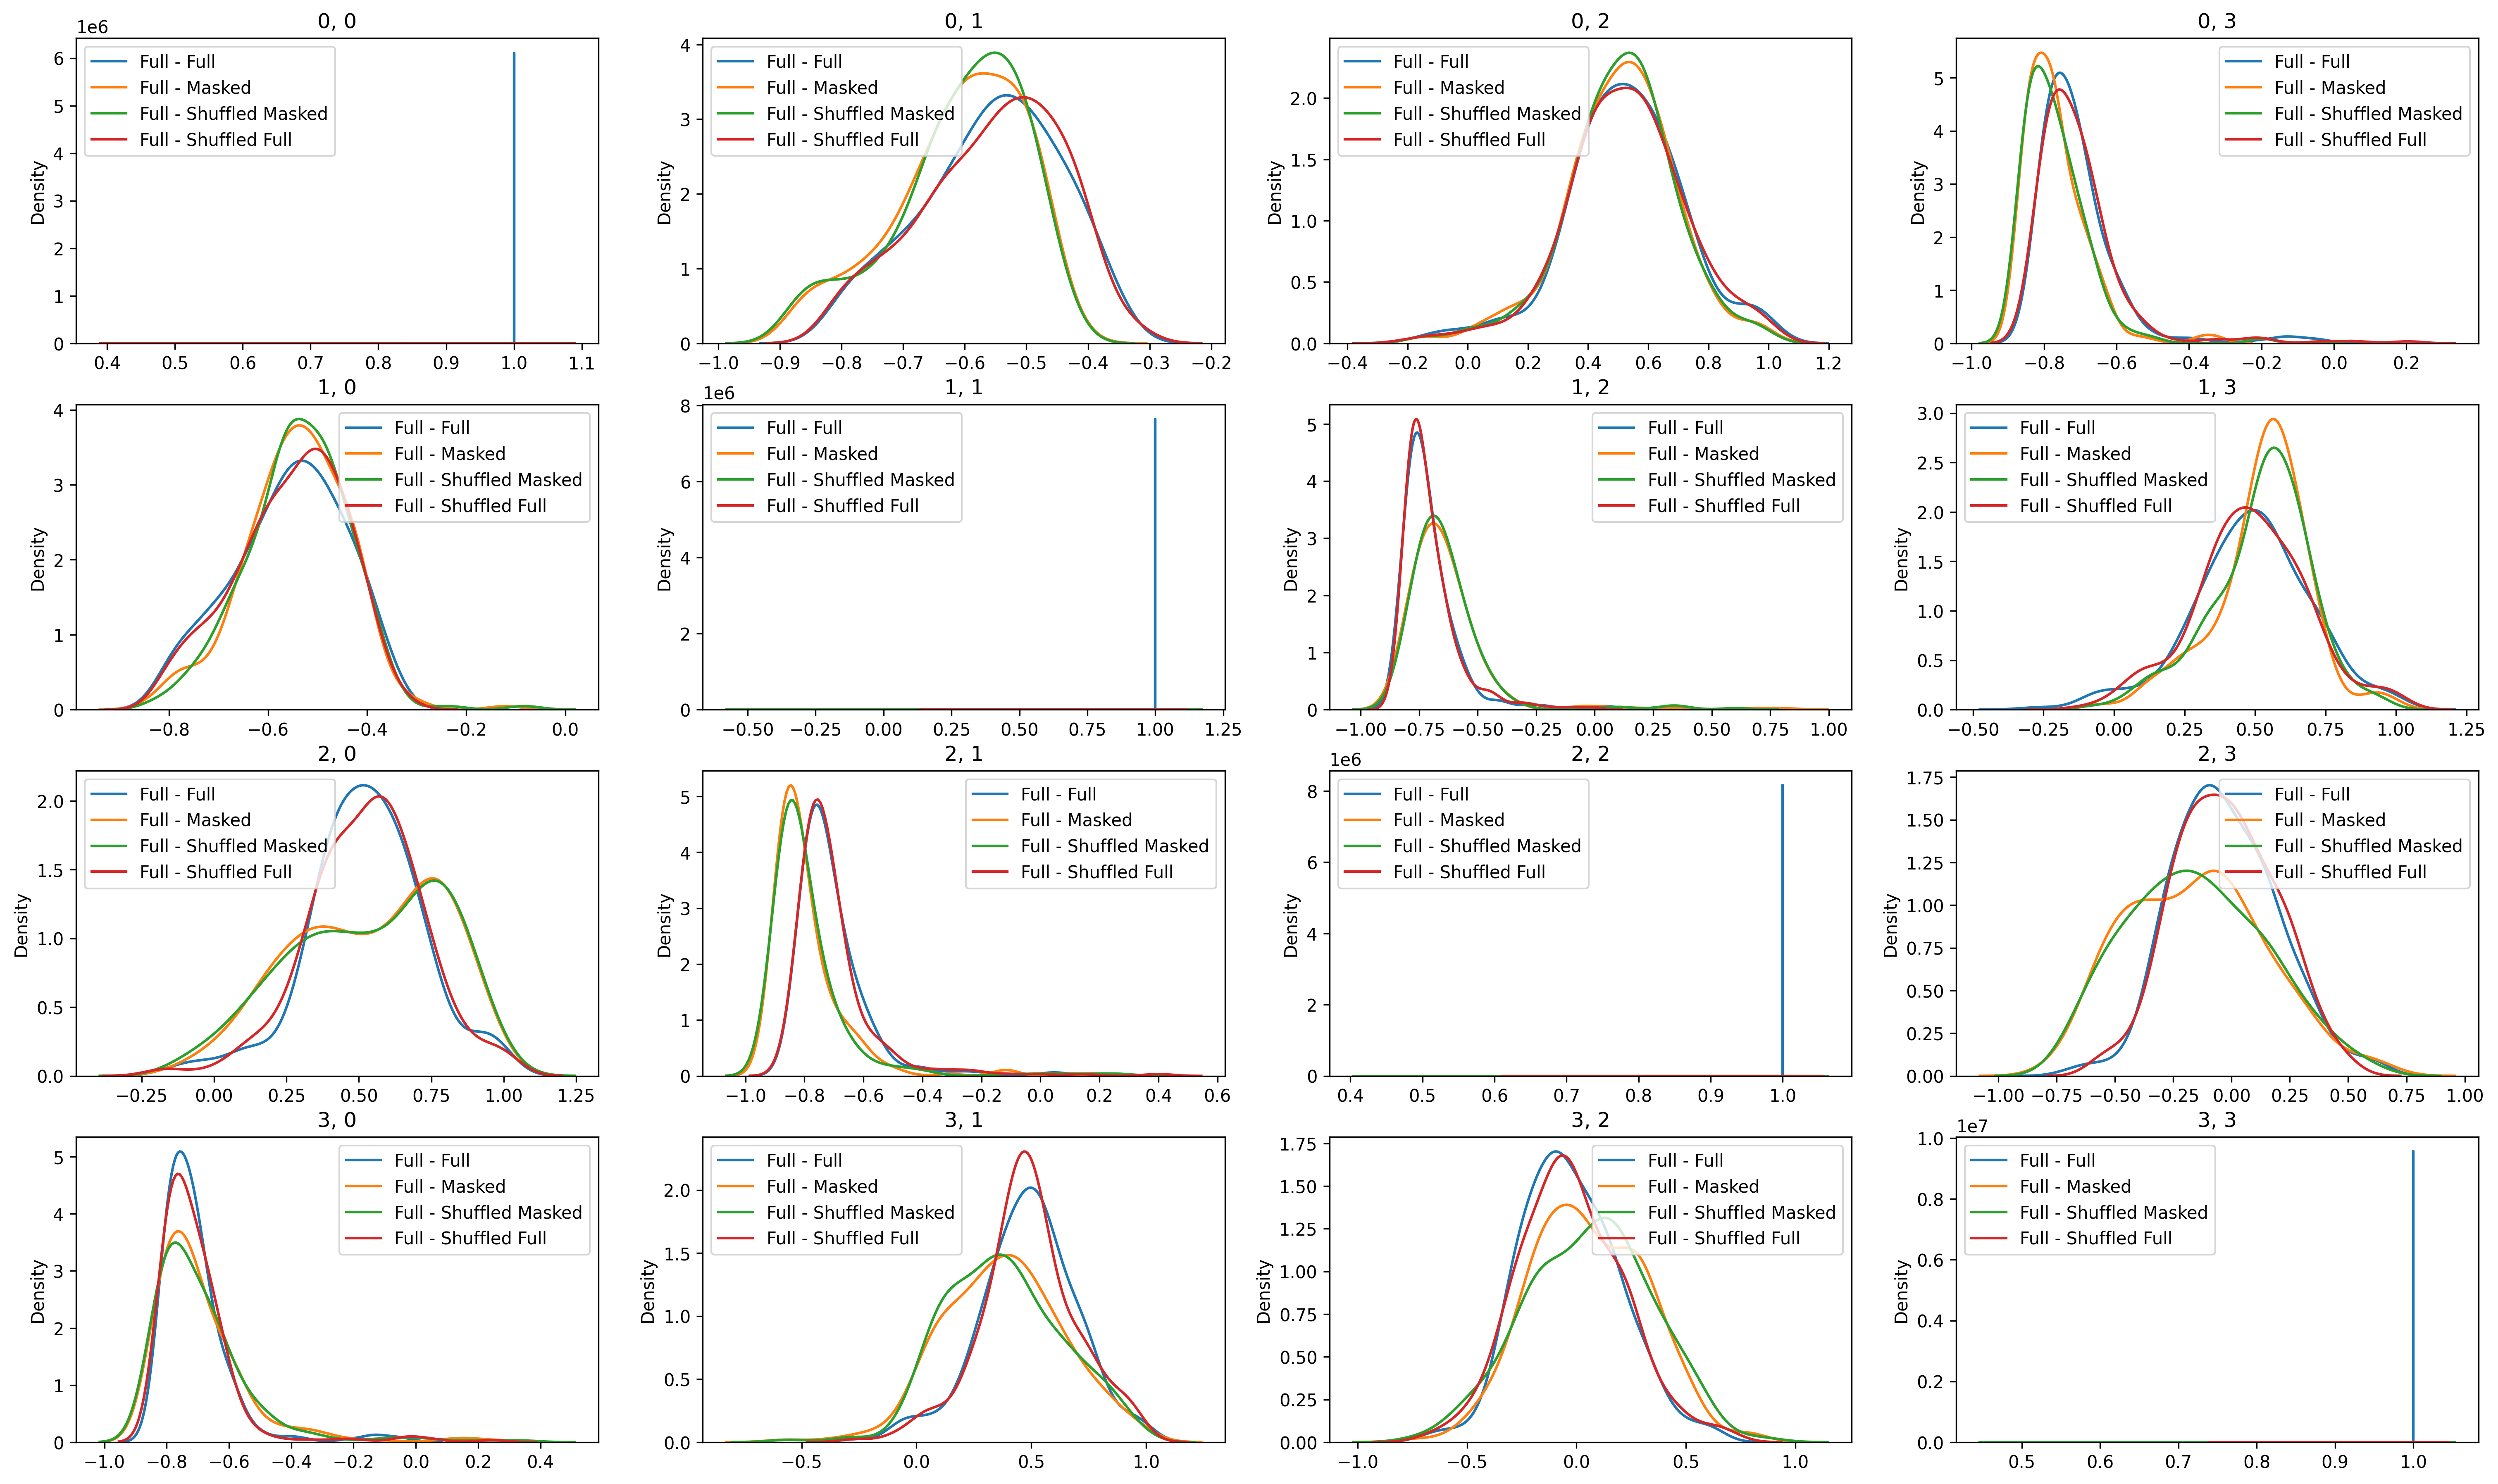

In [23]:
import seaborn as sns

fig, ax = plt.subplots(4, 4, dpi = 300)
fig.set_size_inches(25, 15)

for i, j in zip(xl.flatten(), yl.flatten()):
    k = (4 * i) + j
    #ax[i,j].hist([sim_matrix_fz[k], sim_matrix_mf[k], sim_matrix_shuffle_mf[k]], label = [,], bins = 10)
    sns.kdeplot(sim_matrix_fz[k], label = 'Full - Full', ax = ax[i,j])
    sns.kdeplot(sim_matrix_mf[k], label = 'Full - Masked', ax = ax[i,j])
    sns.kdeplot(sim_matrix_shuffle_mf[k], label = 'Full - Shuffled Masked', ax = ax[i,j])
    sns.kdeplot(sim_matrix_shuffle_f[k], label = 'Full - Shuffled Full', ax = ax[i,j])
    ax[i,j].set_title('{}, {}'.format(i, j))
    ax[i,j].legend()
    
plt.show()

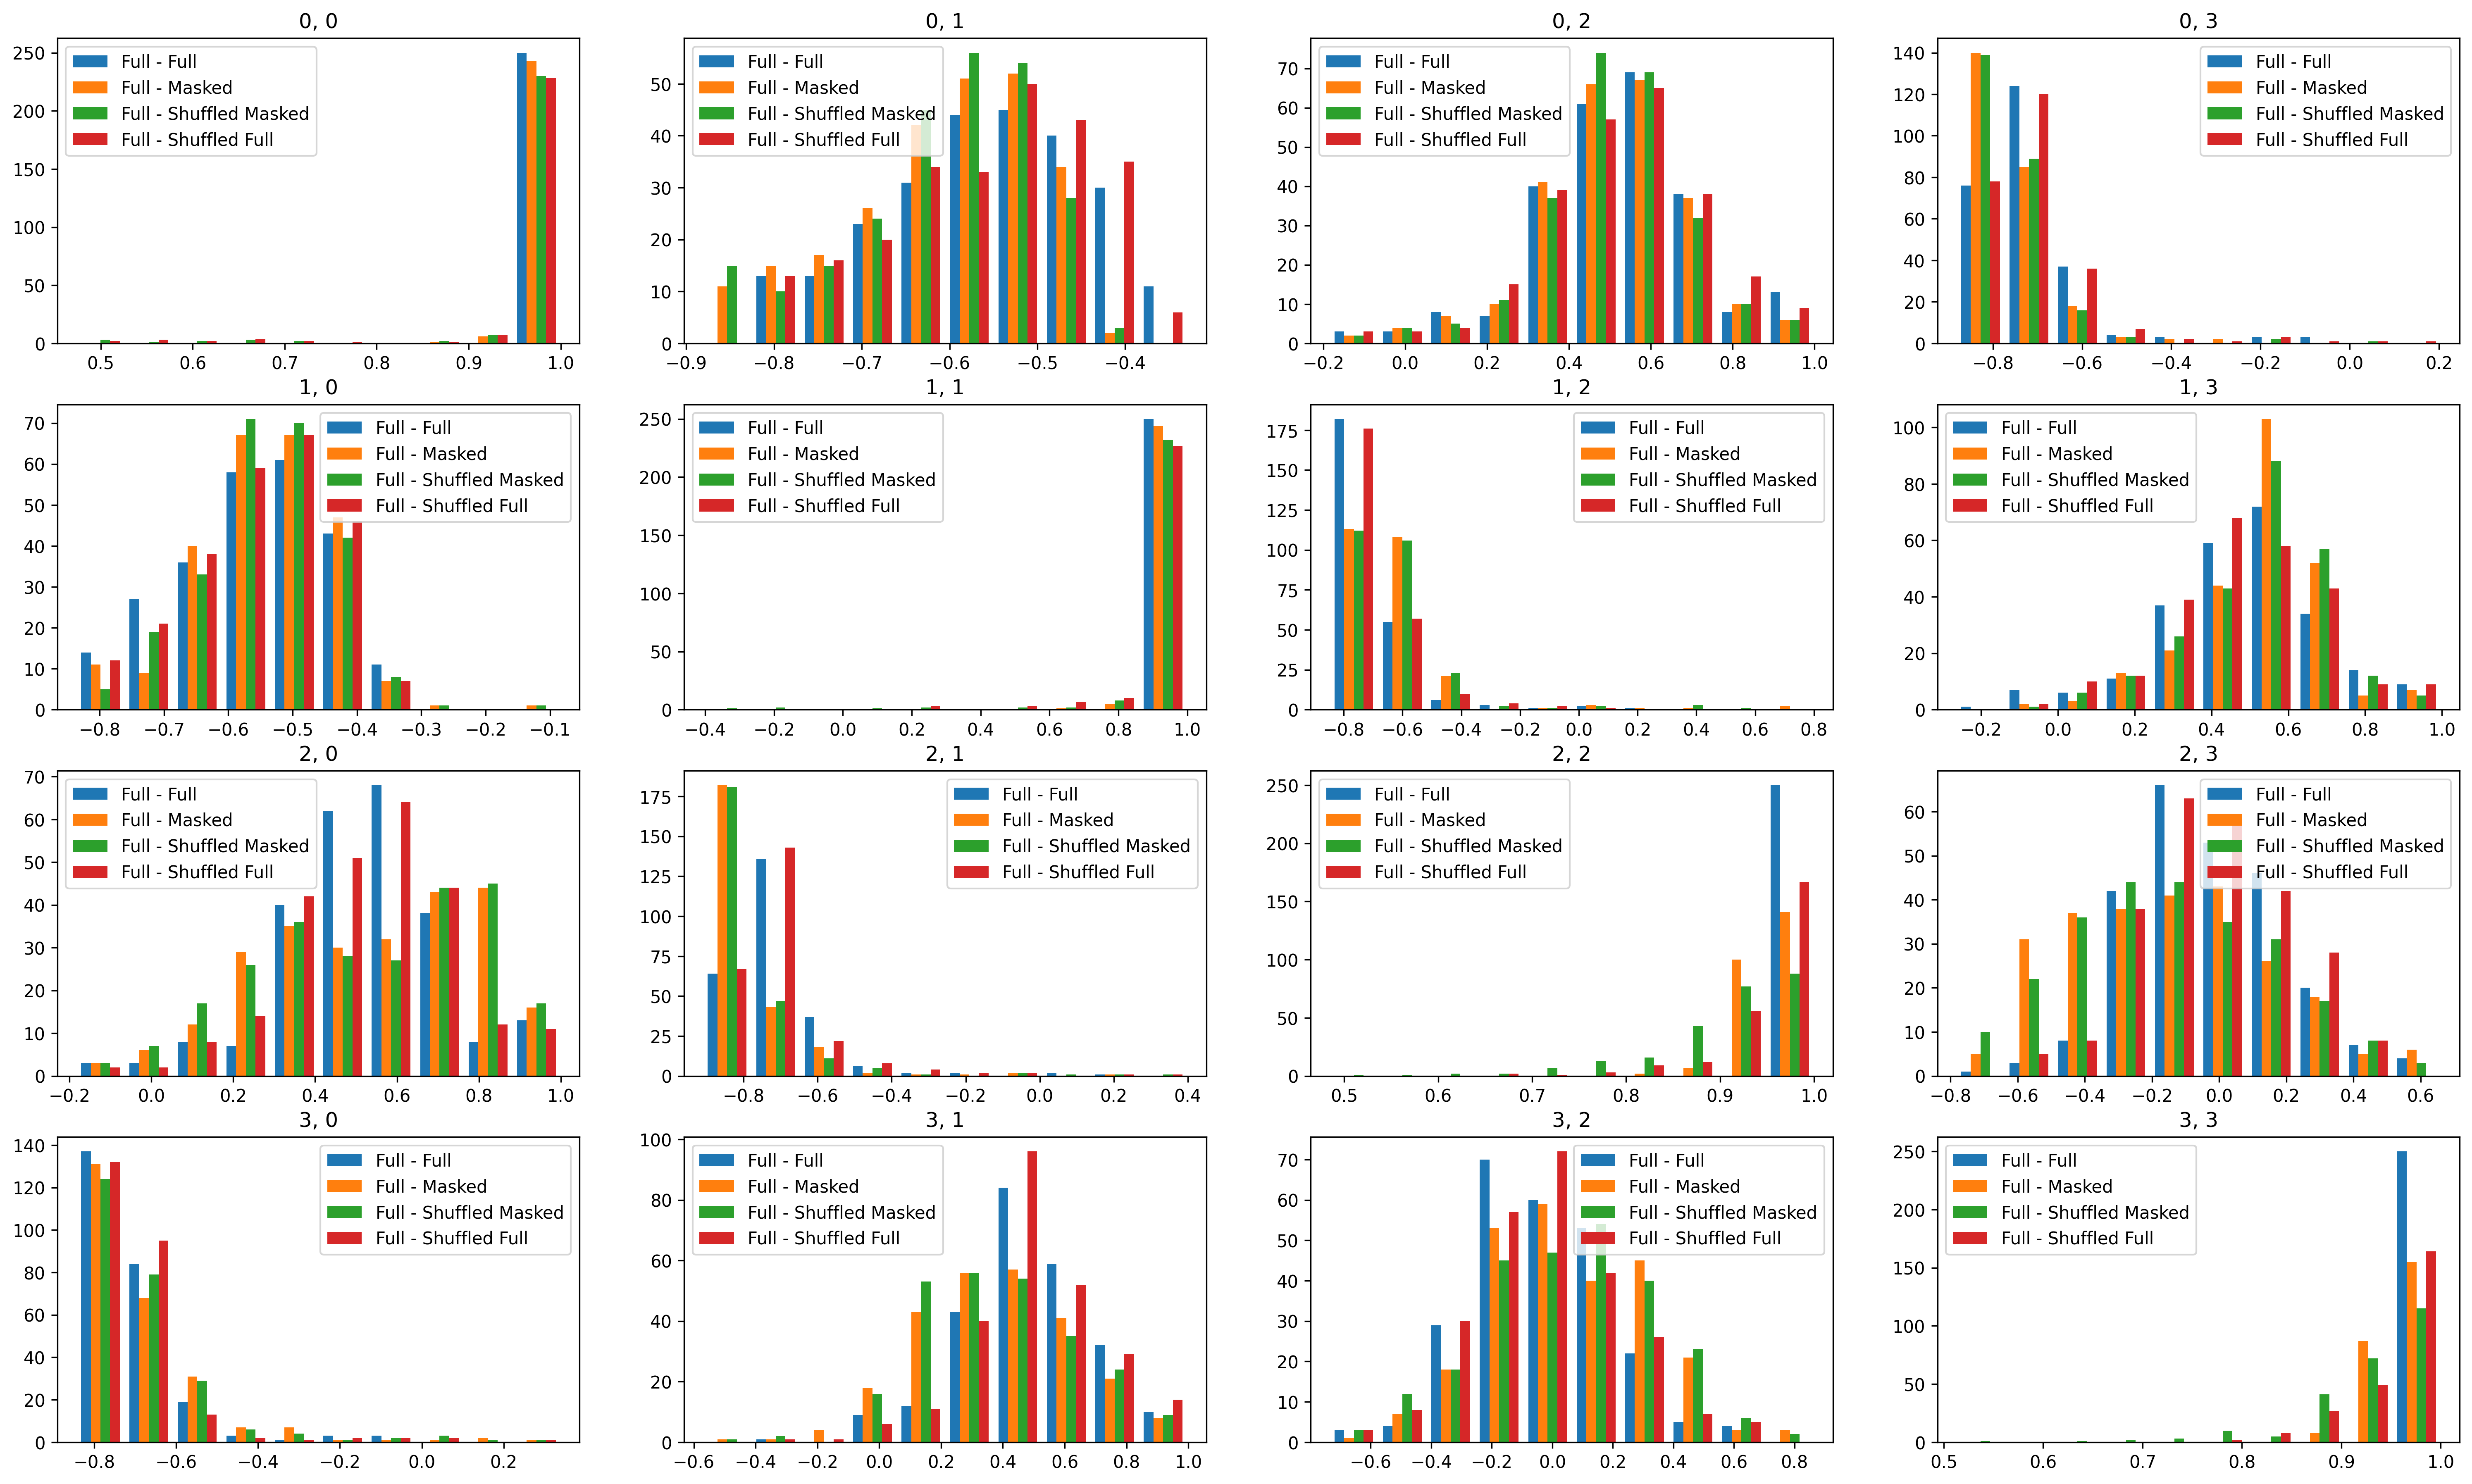

In [24]:
fig, ax = plt.subplots(4, 4, dpi = 300)
fig.set_size_inches(25, 15)

for i, j in zip(xl.flatten(), yl.flatten()):
    k = (4 * i) + j
    ax[i,j].hist([sim_matrix_fz[k], sim_matrix_mf[k], sim_matrix_shuffle_mf[k], sim_matrix_shuffle_f[k]], label = ['Full - Full', 'Full - Masked', 'Full - Shuffled Masked', 'Full - Shuffled Full'], bins = 10)
#     sns.kdeplot(sim_matrix_fz[k], label = 'Full - Full', ax = ax[i,j])
#     sns.kdeplot(sim_matrix_mf[k], label = 'Full - Masked', ax = ax[i,j])
#     sns.kdeplot(sim_matrix_shuffle_mf[k], label = 'Full - Shuffled Masked', ax = ax[i,j])
    ax[i,j].set_title('{}, {}'.format(i, j))
    ax[i,j].legend()
    
plt.show()